<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/Lev_droplet_st_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Determination of ST by NN using coords (rho,theta, volume, volt)

In [ ]:
# Use seaborn for pairplot
#!pip install seaborn
#!pip install talos
#!pip install -q  --no-deps tensorflow-addons~=0.7

In [1]:
!pip install lmfit
!pip install tensorflow_addons

     |████████████████████████████████| 307kB 8.7MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 256kB 33.6MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85265 sha256=63dbc29f4660e035036e0e8c2043eca1b01c18ea88981bde0c55cfae3eb1ba03
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.23-cp37-none-any.whl size=17419 sha256=71ec130dcb2c4e06e9d50d4b3bf163038e2cbdb84dad7feba44bbc74d1b5745f
  Stored in directory: /root/.cache/pip/wheels/56/d6/43/4b5d8a9fd98b976031768673658c8b8d08dc9dcc0fa1907ad0
Successfully built lmfit asteval
     |████████████████████████████████| 706kB 7.8MB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import pprint
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_addons as tfa

print(tf.__version__)


Instructions for updating:
non-resource variables are not supported in the long term
2.4.1


Run the next code box only if google drive is not mounted to colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If it **is** mounted continue from here on

Check the connection to google's **GPU**

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Or** check the connection to google's **TPU**

In [ ]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

### Get the data
First download the dataset!

**Option 1**: Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
csvfilename=str('TritonX100_conci_0.0100_all.csv')
input = pd.read_csv(io.BytesIO(uploaded[csvfilename]))
#input = pd.read_csv(csvfilename, sep="\t")
# Dataset is now stored in a Pandas Dataframe
input.shape

**Option 2**: Import files from drive

In [7]:
#From the drive folder that is mounted to collab go to the file that you are interested in, 
#right click and copy the path of the file. Paste it in csvfilename:
path=str('/content/drive/My Drive/DropLev/Levitator_2/Training/')

fileSDS1=pd.read_csv(str(path+'SDS/SDS_conci_0.01054_all.csv'), sep="\t")
fileSDS2=pd.read_csv(str(path+'SDS/SDS_conci_0.02108_all.csv'), sep='\t')
fileSDS3=pd.read_csv(str(path+'SDS/SDS_conci_0.04273_all.csv'), sep='\t')
fileSDS4=pd.read_csv(str(path+'SDS/SDS_conci_0.08828_all.csv'), sep="\t")
fileSDS5=pd.read_csv(str(path+'SDS/SDS_conci_0.25000_all.csv'), sep="\t")
fileSDS6=pd.read_csv(str(path+'SDS/SDS_conci_0.50000_all.csv'), sep="\t")
fileSDS7=pd.read_csv(str(path+'SDS/SDS_conci_0.75000_all.csv'), sep="\t")
fileSDS8=pd.read_csv(str(path+'SDS/SDS_conci_1.00000_all.csv'), sep="\t")
fileSDS9=pd.read_csv(str(path+'SDS/SDS_conci_1.25000_all.csv'), sep="\t")
fileSDS10=pd.read_csv(str(path+'SDS/SDS_conci_1.50000_all.csv'), sep="\t")
fileSDS11=pd.read_csv(str(path+'SDS/SDS_conci_2.00000_all.csv'), sep="\t")
fileSDS12=pd.read_csv(str(path+'SDS/SDS_conci_2.50000_all.csv'), sep="\t")
fileSDS13=pd.read_csv(str(path+'SDS/SDS_conci_3.00000_all.csv'), sep="\t")
fileSDS14=pd.read_csv(str(path+'SDS/SDS_conci_3.50000_all.csv'), sep="\t")
fileSDS15=pd.read_csv(str(path+'SDS/SDS_conci_4.00000_all.csv'), sep="\t")
fileSDS16=pd.read_csv(str(path+'SDS/SDS_conci_4.50000_all.csv'), sep="\t")
fileSDS17=pd.read_csv(str(path+'SDS/SDS_conci_5.50000_all.csv'), sep="\t")
fileSDS18=pd.read_csv(str(path+'SDS/SDS_conci_6.50000_all.csv'), sep="\t")
fileSDS19=pd.read_csv(str(path+'SDS/SDS_conci_7.50000_all.csv'), sep="\t")
fileSDS20=pd.read_csv(str(path+'SDS/SDS_conci_8.50000_all.csv'), sep="\t")
fileSDS21=pd.read_csv(str(path+'SDS/SDS_conci_24.75900_all.csv'), sep="\t")

fileTrit1=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00250_all.csv'), sep="\t")
fileTrit2=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00500_all.csv'), sep="\t")
fileTrit3=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00750_all.csv'), sep="\t")
fileTrit4=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.01000_all.csv'), sep="\t")
fileTrit5=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.01500_all.csv'), sep="\t")
fileTrit6=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.02000_all.csv'), sep="\t")
fileTrit7=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.02500_all.csv'), sep="\t")
fileTrit8=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.03500_all.csv'), sep="\t")
fileTrit9=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.05000_all.csv'), sep="\t")
fileTrit10=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.07500_all.csv'), sep="\t")
fileTrit11=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.10000_all.csv'), sep="\t")
fileTrit12=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.12500_all.csv'), sep="\t")
fileTrit13=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.15000_all.csv'), sep="\t")
fileTrit14=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.17500_all.csv'), sep="\t")
fileTrit15=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.20000_all.csv'), sep="\t")
fileTrit16=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.25000_all.csv'), sep="\t")
fileTrit17=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.30000_all.csv'), sep="\t")
fileTrit18=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.45000_all.csv'), sep="\t")
fileTrit19=pd.read_csv(str(path+'TritonX100/TritonX_conci_1.00000_all.csv'), sep="\t")
fileTrit20=pd.read_csv(str(path+'TritonX100/TritonX_conci_3.00000_all.csv'), sep="\t")
fileTrit21=pd.read_csv(str(path+'TritonX100/TritonX_conci_10.00000_all.csv'), sep="\t")

fileCTAB1=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00100_all.csv'), sep="\t")
fileCTAB2=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00200_all.csv'), sep="\t")
fileCTAB3=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00500_all.csv'), sep="\t")
fileCTAB4=pd.read_csv(str(path+'CTAB/CTAB_conci_0.01000_all.csv'), sep="\t")
fileCTAB5=pd.read_csv(str(path+'CTAB/CTAB_conci_0.01500_all.csv'), sep="\t")
fileCTAB6=pd.read_csv(str(path+'CTAB/CTAB_conci_0.05500_all.csv'), sep="\t")
fileCTAB7=pd.read_csv(str(path+'CTAB/CTAB_conci_0.10000_all.csv'), sep="\t")
fileCTAB8=pd.read_csv(str(path+'CTAB/CTAB_conci_0.15000_all.csv'), sep="\t")
fileCTAB9=pd.read_csv(str(path+'CTAB/CTAB_conci_0.20000_all.csv'), sep="\t")
fileCTAB10=pd.read_csv(str(path+'CTAB/CTAB_conci_0.25000_all.csv'), sep="\t")
fileCTAB11=pd.read_csv(str(path+'CTAB/CTAB_conci_0.30000_all.csv'), sep="\t")
fileCTAB12=pd.read_csv(str(path+'CTAB/CTAB_conci_0.40000_all.csv'), sep="\t")
fileCTAB13=pd.read_csv(str(path+'CTAB/CTAB_conci_0.50000_all.csv'), sep="\t")
fileCTAB14=pd.read_csv(str(path+'CTAB/CTAB_conci_0.60000_all.csv'), sep="\t")
fileCTAB15=pd.read_csv(str(path+'CTAB/CTAB_conci_0.70000_all.csv'), sep="\t")
fileCTAB16=pd.read_csv(str(path+'CTAB/CTAB_conci_0.80000_all.csv'), sep="\t")
fileCTAB17=pd.read_csv(str(path+'CTAB/CTAB_conci_0.85000_all.csv'), sep="\t")
fileCTAB18=pd.read_csv(str(path+'CTAB/CTAB_conci_0.90000_all.csv'), sep="\t")
fileCTAB19=pd.read_csv(str(path+'CTAB/CTAB_conci_1.00000_all.csv'), sep="\t")
fileCTAB20=pd.read_csv(str(path+'CTAB/CTAB_conci_5.00000_all.csv'), sep="\t")
fileCTAB21=pd.read_csv(str(path+'CTAB/CTAB_conci_13.15224_all.csv'), sep="\t")

#input=np.vstack([fileSDS1, fileSDS2, fileSDS3, fileSDS4, fileSDS5, fileSDS6, fileSDS7, fileSDS8, fileSDS9, fileSDS10, fileSDS11, 
                 #fileSDS12, fileSDS13, fileSDS14, fileSDS15, fileSDS16, fileSDS17, fileSDS18, fileSDS19, fileSDS20, fileSDS21,
                # fileTrit1, fileTrit2, fileTrit3, fileTrit4, fileTrit5, fileTrit6, fileTrit7, fileTrit8, fileTrit9, fileTrit10, fileTrit11,
                # fileTrit12, fileTrit13, fileTrit14, fileTrit15, fileTrit16, fileTrit17, fileTrit18, fileTrit19, fileTrit20, fileTrit21,
                # fileCTAB1, fileCTAB2, fileCTAB3, fileCTAB4, fileCTAB5, fileCTAB6, fileCTAB7, fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB11,
                # fileCTAB12, fileCTAB13, fileCTAB14, fileCTAB15, fileCTAB16, fileCTAB17, fileCTAB18, fileCTAB19, fileCTAB20, fileCTAB21])
# input=np.vstack([fileSDS5, fileSDS6, fileSDS7, fileSDS8, fileSDS9, fileSDS10, fileSDS13, fileSDS14,
#                  fileTrit7, fileTrit8, fileTrit9, fileTrit10, fileTrit11,
#                  fileCTAB9, fileCTAB10, fileCTAB11, fileCTAB12,fileCTAB13, fileCTAB14])
# input.shape

#csvfilename=str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_ML_data.csv')

#input = pd.read_csv(csvfilename)

In [16]:
# input=np.vstack([fileSDS1, fileSDS2, fileSDS3, fileSDS4, fileSDS5, fileSDS6, fileSDS7, fileSDS19, fileSDS20, fileSDS21,
#                  fileTrit1, fileTrit2, fileTrit3, fileTrit4, fileTrit5, fileTrit17, fileTrit18, fileTrit19, fileTrit20, fileTrit21,
#                  fileCTAB1, fileCTAB2, fileCTAB3, fileCTAB4, fileCTAB5, fileCTAB15, fileCTAB16, fileCTAB17, fileCTAB18, fileCTAB19, fileCTAB20, fileCTAB21])

input=np.vstack([fileSDS8, fileSDS9, fileSDS10, fileSDS11, fileSDS12, fileSDS13, fileSDS14, fileSDS15, fileSDS16, fileSDS17, fileSDS18,
                 fileTrit6, fileTrit7, fileTrit8, fileTrit9, fileTrit10, fileTrit11, fileTrit12, fileTrit13, fileTrit14, fileTrit15, fileTrit16,
                 fileCTAB6, fileCTAB7, fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB11, fileCTAB12, fileCTAB13, fileCTAB14])

# input=np.vstack([fileTrit6, fileTrit7, fileTrit8, fileTrit9, fileTrit10, fileTrit11, fileTrit12, fileTrit13, fileTrit14, fileTrit15, fileTrit16])

# input=np.vstack([fileCTAB10, fileCTAB11])

In [17]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
for i in range(300):
  column_names.append('phi_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
column_names.append('height')
column_names.append('width')  
column_names.append('volume')
column_names.append('R_sph')
column_names.append('volt')
column_names.append('Intensity')
column_names.append('time')
column_names.append('Power')
#column_names.append('Ps')
#column_names.append('Ps_err')
column_names.append('centre_x')
column_names.append('centre_y')
column_names.append('surfactant_conc')
column_names.append('Aspect_Ratio')
column_names.append('st')


#raw_dataset = pd.read_csv(csvfilename, sep="\t")
#raw_dataset.columns=column_names

raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape

dataset = raw_dataset.copy()

for i in range(300):
 dataset.pop('rho_%d' %i)
for i in range(300):
  dataset.pop('phi_%d' %i)
for i in range(300):
 dataset.pop('theta_%d' %i)
dataset.pop("height")
dataset.pop("width")
#dataset.pop("volume")
dataset.pop("R_sph")
dataset.pop('volt')
dataset.pop('Intensity')
dataset.pop('time')
# dataset.pop('Power')
#dataset.pop('Ps')
#dataset.pop('Ps_err')
dataset.pop("centre_x")
# dataset.pop("centre_y")
dataset.pop('surfactant_conc')
# dataset.pop("Aspect_Ratio")

dataset.tail()

#We keep: volume	Power	centre_y	Aspect_Ratio	st

,volume,Power,centre_y,Aspect_Ratio,st
156655,1.764766,3.00604,1.776659,1.319018,38.500904
156656,1.762896,3.00604,1.776659,1.319018,38.499712
156657,1.768315,3.00604,1.765184,1.319018,38.503163
156658,1.753342,3.00604,1.784309,1.301829,38.493602
156659,1.750045,3.00604,1.791959,1.301829,38.491487


In [ ]:
#Drop 125 values of theta
for i in range(0,150):
  dataset=dataset.drop(dataset.columns[300+i], axis=1)
  i=i+1


#Drop 125 values of rho:
for i in range(0,150):
  dataset=dataset.drop(dataset.columns[i], axis=1)
  i=i+1



# dataset.pop('R_sph')

dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,phi_229,phi_231,phi_233,phi_235,phi_237,phi_239,phi_241,phi_243,phi_245,phi_247,phi_249,phi_251,phi_253,phi_255,phi_257,phi_259,phi_261,phi_263,phi_265,phi_267,phi_269,phi_271,phi_273,phi_275,phi_277,phi_279,phi_281,phi_283,phi_285,phi_287,phi_289,phi_291,phi_293,phi_295,phi_297,phi_299,volume,R_sph,volt,st
161330,0.701388,0.702297,0.700892,0.696702,0.692601,0.683902,0.682661,0.679565,0.673910,0.668012,0.651712,0.645341,0.636919,0.622031,0.617834,0.598273,0.589880,0.588071,0.578039,0.575526,0.570301,0.564835,0.560623,0.560352,0.553637,0.552432,0.547251,0.545513,0.542329,0.536524,0.536889,0.532660,0.534141,0.531530,0.530588,0.529562,0.529220,0.531530,0.529863,0.533965,...,1.817517,1.852029,1.881311,1.981203,2.003204,2.025098,2.074546,2.117077,2.173779,2.214297,2.228924,2.286540,2.319514,2.365285,2.440439,2.461993,2.500558,2.529866,2.558624,2.608353,2.640827,2.709185,2.752549,2.800096,2.812674,2.839378,2.857125,2.869447,2.906048,2.923525,2.940940,2.992703,3.015198,3.043012,3.092719,3.136158,1.098164,0.640019,8.92,35.444797
161331,0.701212,0.702575,0.697918,0.692978,0.690893,0.685247,0.685078,0.675199,0.672435,0.671906,0.651712,0.644195,0.636919,0.624972,0.617505,0.593481,0.591806,0.585712,0.578039,0.577675,0.569449,0.566770,0.564335,0.560352,0.556875,0.552432,0.550052,0.544223,0.541299,0.537429,0.536889,0.533965,0.535808,0.532715,0.531898,0.531189,0.530096,0.529343,0.531898,0.533163,...,1.808843,1.838302,1.888063,1.968295,1.996844,2.009527,2.089942,2.111216,2.164406,2.203545,2.243467,2.291470,2.333367,2.347104,2.427502,2.449258,2.491919,2.521343,2.575326,2.608353,2.624662,2.703913,2.739722,2.787479,2.812674,2.832319,2.844748,2.869447,2.899320,2.911458,2.935521,2.981854,3.004340,3.032142,3.114425,3.141593,1.097919,0.639971,8.92,35.444606
161332,0.704399,0.705838,0.703194,0.702225,0.695452,0.691910,0.683881,0.682789,0.676604,0.671486,0.669334,0.652301,0.644195,0.636008,0.621542,0.617505,0.598540,0.587479,0.585712,0.578916,0.573393,0.571469,0.566219,0.562147,0.558577,0.552051,0.550921,0.545885,0.544250,0.541299,0.539354,0.536119,0.532048,0.532715,0.531530,0.530875,0.529891,0.529275,0.529562,0.530328,...,1.852029,1.874531,1.901475,1.987603,2.031338,2.065203,2.117077,2.169972,2.184815,2.228924,2.263007,2.296358,2.324242,2.360719,2.400808,2.444460,2.487022,2.512796,2.545215,2.586800,2.630487,2.659574,2.675334,2.749434,2.782158,2.826959,2.853339,2.870944,2.883138,2.907337,2.936646,2.948498,2.971043,3.015885,3.060251,3.109172,1.098068,0.640000,8.92,35.444722
161333,0.708904,0.705964,0.704474,0.700036,0.695809,0.690581,0.689289,0.682462,0.676682,0.674192,0.654057,0.647542,0.638956,0.623768,0.616968,0.596663,0.587901,0.586000,0.578744,0.572979,0.570774,0.565133,0.560808,0.557125,0.550081,0.548749,0.543333,0.541436,0.537904,0.531888,0.532105,0.527674,0.529580,0.527976,0.525844,0.525182,0.524394,0.523731,0.523634,0.524187,...,1.813129,1.850092,1.877758,1.978945,2.001228,2.023403,2.073487,2.116557,2.173964,2.214972,2.229774,2.283722,2.321406,2.363059,2.438780,2.460492,2.499333,2.528851,2.557813,2.602717,2.635361,2.706546,2.749893,2.797424,2.809995,2.836699,2.856013,2.868262,2.903348,2.922027,2.939340,2.990812,3.013182,3.040842,3.090286,3.133528,1.094999,0.639404,8.92,35.442326
161334,0.707738,0.705430,0.705101,0.701039,0.694443,0.689341,0.680516,0.673654,0.671316,0.659233,0.654766,0.651992,0.628986,0.620564,0.613552,0.601743,0.594436,0.572511,0.569172,0.565210,0.560083,0.557892,0.549185,0.547797,0.546672,0.544400,0.540029,0.537729,0.533452,0.528278,0.527990,0.525844,0.523772,0.522608,0.525582,0.521637,0.521776,0.522608,0.524132,0.527797,...,1.889134,1.918648,1.938737,1.967770,2.018697,2.096380,2.123575,2.138840,2.215641,2.239778,2.293340,2.330796,2.372138,2.421271,2.

In [ ]:
#Drop 125 values of theta
for i in range(0,25):
  dataset=dataset.drop(dataset.columns[125+i], axis=1)
  i=i+15


#Drop 125 values of rho:
for i in range(0,25):
  dataset=dataset.drop(dataset.columns[i], axis=1)
  i=i+15

dataset.tail()

In [ ]:
# volt=dataset['volt']

In [ ]:
# dataset.pop('volt')

In [ ]:
# shift=50
# datset=dataset
# for i in range(shift):
#   datset=datset.drop([i], axis=0)
# datset.shape
# datset.head()

In [ ]:
# volt2=volt
# for i in range(1, 51):
#   j=1
#   volt2=volt2.drop(len(volt2)-j, axis=0)
# volt2.tail()

In [ ]:
# volt2=np.asarray(volt2)

In [ ]:
# datset['volt']=volt2
# datset.tail()


In [ ]:
# dataset=datset
# dataset.head()

In [ ]:
#Check that the drop contour is still well defined!
plt.plot(dataset.iloc[600, 100:200], dataset.iloc[600, 0:100])

### Show the Volume and ST distribution of the data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0, 0.5, 'Count')

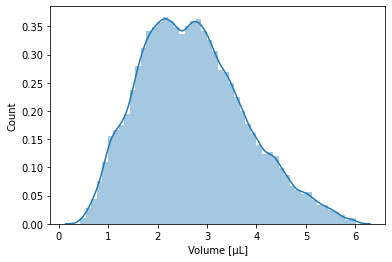

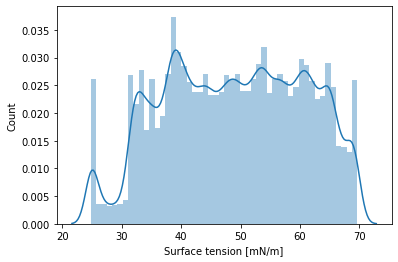

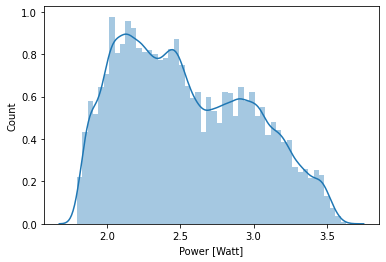

In [18]:
#linex=np.tile(3, 2)
#liney=[0, 0.3]

plt.figure()
sns.distplot(dataset['volume'])
plt.xlabel('Volume [μL]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset['st'])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset['Power'])
plt.xlabel('Power [Watt]')
plt.ylabel('Count')


### Selectively choose data with (almost) constant volume

In [ ]:
new_input=[]
vol_min=2.99
vol_max=3.01
for i in range(len(dataset)):
  if dataset['volume'].iloc[i] >= vol_min and dataset['volume'].iloc[i] <= vol_max:
    vol_ct_data=dataset.iloc[i, :]
    new_input.append(vol_ct_data)
new_input=np.asarray(new_input)
new_input.shape

In [ ]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
column_names.append('volume')
column_names.append('R_sph')
column_names.append('volt')
column_names.append('st')

new_dataset=pd.DataFrame(new_input, columns=column_names)
new_dataset.pop('R_sph')
new_dataset.tail()

In [ ]:
plt.figure()
sns.distplot(new_dataset['volt'])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

plt.figure()
sns.distplot(new_dataset['st'])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

In [ ]:
# #Drop 125 values of theta
# for i in range(0,125):
#   new_dataset=new_dataset.drop(new_dataset.columns[300+i], axis=1)
#   i=i+1


# #Drop 125 values of theta
# for i in range(0,125):
#   new_dataset=new_dataset.drop(new_dataset.columns[i], axis=1)
#   i=i+1

# #Drop voltage
# new_dataset.pop('volt')


In [ ]:
# #Drop volume if it's constant
# new_dataset.pop('volume')

In [ ]:
# #Check that the drop contour is still well defined!
# plt.plot(new_dataset.iloc[25, 150:300], new_dataset.iloc[25, 0:150])

In [ ]:
new_input=np.asarray(dataset)

In [ ]:
from lmfit import Model, fit_report, Parameters

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
    rho=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)+R_sph
    return rho
data_Ps=[]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340 #mm^-1

for i in range(len(new_input)):
  gamma=new_input[i, 603]
  R_sph=new_input[i, 601]
  rho=new_input[i, 0:300]
  gmodel = Model(model_fit, nan_policy='omit')
    
  fit_param = Parameters()
  fit_param.add('Ps', value=700, min=10, max=4000)
  
  result = gmodel.fit(rho, th=new_input[i, 300:600], params=fit_param)         #rho_final, th: x and y to be evaluated, respectively
  Ps=result.params['Ps'].value
  data_Ps.append(Ps)
data_Ps=np.asarray(data_Ps)

plt.figure()
plt.plot(data_Ps)
plt.xlabel('Drop')
plt.ylabel('Acoustic pressure [Pa]')

In [ ]:
plt.figure()
plt.plot(new_input[i, 300:600], rho, 'bo')
plt.plot(new_input[i, 300:600], result.best_fit, 'r-', label='best fit')

In [ ]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
column_names.append('volume')
column_names.append('R_sph')
column_names.append('volt')
column_names.append('st')

new_dataset=pd.DataFrame(new_input, columns=column_names)

In [ ]:

#Add the calclulated Ps values to the new_dataset dataframe
new_dataset['Ps']=data_Ps

#Drop the R_sph values since we cannot have them in the prediction
new_dataset.pop('R_sph')
new_dataset.pop('volt')
# new_dataset.pop('volume')
new_dataset.tail()

In [ ]:
dataset=new_dataset
#Drop 125 values of theta
for i in range(0,125):
  dataset=dataset.drop(dataset.columns[300+i], axis=1)
  i=i+1


#Drop 125 values of rho:
for i in range(0,125):
  dataset=dataset.drop(dataset.columns[i], axis=1)
  i=i+1

dataset.tail()

In [ ]:
newer_input=[]
Ps_min=1500
Ps_max=2100
for i in range(len(new_dataset)):
  if new_dataset['Ps'].iloc[i] >= Ps_min and new_dataset['Ps'].iloc[i] <= Ps_max:
    Ps_range=new_dataset.iloc[i, :]
    newer_input.append(Ps_range)
newer_input=np.asarray(newer_input)

newer_input.shape

In [ ]:
plt.figure()
plt.plot(newer_input[:, 601])
plt.ylabel('Acoustic pressure [Pa]')
plt.xlabel('droplet')

In [ ]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
# column_names.append('volume')
column_names.append('st')
column_names.append('Ps')

new_df=pd.DataFrame(newer_input, columns=column_names)

#Drop ST:
new_df.pop('st')

In [ ]:
# dataset.pop('st')

dataset_name=dataset.iloc[80000:90000]

stats_input_df=dataset_name.describe()
stats_input_df=stats_input_df.transpose()
stats_input_df.tail()

In [ ]:
new_dataset.iloc[:, 601]
newer_input=np.asarray(new_dataset.iloc[80000:90000])

In [ ]:
def norm_test(x):
  return (x - stats_input_df['mean']) / stats_input_df['std']

#import model from drive
folder=str('theory_experiment_mix/')
filename=str('All_surf_all_vary_175points_trial_1.h5')
model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)


norm_input_array=norm_test(dataset_name)
prediction=model.predict(norm_input_array).flatten()
true_values=newer_input[:, 601]

plt.figure()
plt.xlabel('Frame number')
plt.ylabel('Surface tension [ mN/m ]')
plt.ylim(20, 75)
plt.plot(prediction, label='Predicted values')
plt.plot(true_values, label='Real values')
plt.legend()

plt.figure()
plt.scatter(true_values, prediction)
plt.title('Normalized new test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

error = prediction - true_values
plt.figure()
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
#plt.ylim(0, 30)
plt.show()


Import it using pandas

In [ ]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
for i in range(300):
  column_names.append('phi_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
column_names.append('height')
column_names.append('width')  
column_names.append('volume')
column_names.append('R_sph')
column_names.append('volt')
column_names.append('Intensity')
column_names.append('time')
column_names.append('Power')
#column_names.append('Ps')
#column_names.append('Ps_err')
column_names.append('centre_x')
column_names.append('centre_y')
column_names.append('surfactant_conc')
column_names.append('Aspect_Ratio')
column_names.append('st')


#raw_dataset = pd.read_csv(csvfilename, sep="\t")
#raw_dataset.columns=column_names

raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              


raw_dataset.shape

dataset = raw_dataset.copy()

#for i in range(300):
#  dataset.pop('rho_%d' %i)
#for i in range(300):
#  dataset.pop('phi_%d' %i)
#for i in range(300):
#  dataset.pop('theta_%d' %i)
dataset.pop("height")
dataset.pop("width")
dataset.pop("volume")
#dataset.pop("R_sph")
#dataset.pop('volt')
dataset.pop('Intensity')
dataset.pop('time')
dataset.pop('Power')
#dataset.pop('Ps')
#dataset.pop('Ps_err')
dataset.pop("centre_x")
dataset.pop("centre_y")
dataset.pop('surfactant_conc')
dataset.pop("Aspect_Ratio")

dataset.tail()

###Adding/Changing feutures

In [ ]:
# dataset['R_sph']=dataset['R_sph']**2

for i in range(300):
  dataset['theta_%d' %i]= (np.cos(dataset['theta_%d' %i]))**2

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [ ]:
dataset['volt']=dataset['volt']*178
dataset.tail()

In [ ]:
dataset.pop('R_sph')
dataset.pop('volume')
dataset.tail()

In [19]:
train_dataset = dataset.sample(frac=0.8,random_state=1)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

Also look at the overall statistics:

In [20]:
train_stats = train_dataset.describe()
train_stats.pop("st")

train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
volume,125328.0,2.712248,1.057960,0.431143,1.920658,2.625074,3.396813,6.006597
Power,125328.0,2.535960,0.439246,1.795200,2.164190,2.468040,2.888360,3.630000
centre_y,125328.0,1.804003,0.169194,1.345894,1.682844,1.783739,1.917586,2.364358
Aspect_Ratio,125328.0,1.334011,0.163549,1.092342,1.221519,1.300000,1.396396,2.535433


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [21]:
train_labels = train_dataset.pop('st')
test_labels = test_dataset.pop('st')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [22]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
#normed_train_data = train_dataset
#normed_test_data = test_dataset


In [ ]:
#to check!

#normed_test_data = tf.nn.batch_normalization(train_dataset, train_stats['mean'], train_stats['std'], offset=None, scale=None, variance_epsilon=1)
#normed_test_data_old = norm(train_dataset)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

## Neural network model

In [23]:
STEPS_PER_EPOCH=len(train_dataset)/500
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [24]:
def build_model():
  model = keras.Sequential([
    layers.Dense(2500, activation=tf.nn.swish, input_shape=[len(train_dataset.keys())]),
    layers.Dense(500, activation=tf.nn.swish),
    # layers.Dense(3, activation=tf.nn.swish),
    layers.Dense(1)
  ])

 # optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mean_squared_error',
                optimizer=get_optimizer(),
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
    # layers.Dense(70, activation=tf.nn.swish),
    # layers.Dense(60, activation=tf.nn.swish),
    # layers.Dense(50, activation=tf.nn.swish),
    # layers.Dense(40, activation=tf.nn.swish),
    # layers.Dense(30, activation=tf.nn.swish),
    # layers.Dense(20, activation=tf.nn.swish),
    # layers.Dense(10, activation=tf.nn.swish),

In [25]:
model = build_model()

## Random forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=10, random_state=0)
model.fit(normed_train_data, train_labels)
predicted = model.predict(normed_test_data)

print('Coefficient R^2:', model.score(normed_test_data, test_labels))


Coefficient R^2: 0.9011559201395274


## Support Vector Machine (SVM)

In [59]:
from sklearn.svm import SVR

model=SVR(C=0.001, kernel='sigmoid', gamma='scale', coef0=1, max_iter=2000)
model.fit(normed_train_data, train_labels)
predicted = model.predict(normed_test_data)

print('Coefficient R^2:', model.score(normed_test_data, test_labels))


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Coefficient R^2: -0.02013237030903814


## If there is a model saved on google drive execute the next block

In [ ]:
from tensorflow.keras.models import load_model

del model 
folder=str('Experimental_surfactants/')
model_name=str('TritonX_all_vary_175points_trial_1.h5')
model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+folder+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2500)              12500     
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1250500   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 1,263,501
Trainable params: 1,263,501
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [27]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


array([[-0.05443232],
       [ 0.00497837],
       [ 0.06555058],
       [ 0.03061546],
       [-0.03634379],
       [-0.01426938],
       [ 0.02127873],
       [-0.01192214],
       [-0.07664655],
       [-0.00948929]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [1]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 55 == 0: print('')
    print('.', end='')


EPOCHS = 200


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=15, verbose=0, mode='auto')


history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])  # callbacks=callbacks_list

NameError: ignored

Visualize the model's training progress using the stats stored in the `history` object.

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,4.339959,1.344712,4.339964,4.858629,1.426651,4.858628,995
996,4.341572,1.343027,4.341576,4.862009,1.418638,4.862008,996
997,4.341613,1.343655,4.341615,4.894823,1.428940,4.894823,997
998,4.337558,1.341786,4.337556,4.861349,1.417788,4.861348,998
999,4.334665,1.342600,4.334663,4.891584,1.431068,4.891588,999


Let's automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

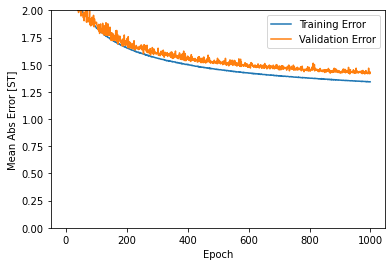

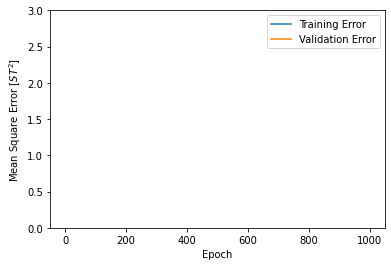

In [30]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Validation Error')
  plt.ylim([0,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Validation Error')
  plt.ylim([0,3])
  plt.legend()
  plt.show()


plot_history(history)

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [31]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))
# keras.metrics.accuracy(normed_test_data, test_labels)

Testing set Mean Abs Error:  1.41 mN/m


### Make predictions

Finally, predict volume values using data in the testing set:

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([20,75])
plt.ylim([20,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2 = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([20,75])
plt.ylim([20,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [surface tension - mN/m]")
_ = plt.ylabel("Count")
# plt.xlim(-20, 20)
plt.show()

# Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
folder=str('Experimental_surfactants/')
filename=str('TritonX_all_vary_175points_trial_2.h5')
!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)  #Saves the file

The SavedModel format is a directory containing a protobuf binary and a Tensorflow checkpoint. Inspect the saved model directory:

In [ ]:
# DropLev_st_prediction_model directory
#!ls content/drive/My Drive/DropLev/MachineLearningModels

# Contains an assets folder, saved_model.pb, and variables folder.
#!ls content/drive/My Drive/DropLev/MachineLearningModels/SDS_1.h5

Saving the model in a **HDF5** format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
#model.save('content/drive/My Drive/DropLev/MachineLearningModels/'+filename) 

# Reload a fresh Keras model from the saved model:

For **SavedModel** format

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)

# Check its architecture
new_model.summary()

For **HDF5** format

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('DropLev_st_prediction_model.h5')

# Show the model architecture
new_model.summary()

Evaluate the restored model (for both formats)

In [ ]:
# Evaluation
loss, mae, mse = new_model.evaluate(normed_test_data, test_labels, verbose=0)
print('Restored model, Mean absolute error: {:5.2f}'.format(mae))

print(new_model.predict(normed_test_data).shape)